In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
# %matplotlib widget
# import ipywidgets as widgets

In [3]:
_parent_folder = "omni_9dof_feb_28_2023"
_folder_name = "sk27_00_random_slow"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\simulation\\..\\recording_programs\\test_data\\omni_9dof_feb_28_2023'

In [4]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)
_sk_df["e_t"] =  -_sk_df["e_t"]
_sk_df["e_rr"] = -_sk_df["e_rr"]
_sk_df["e_rl"] = _sk_df["e_rl"]

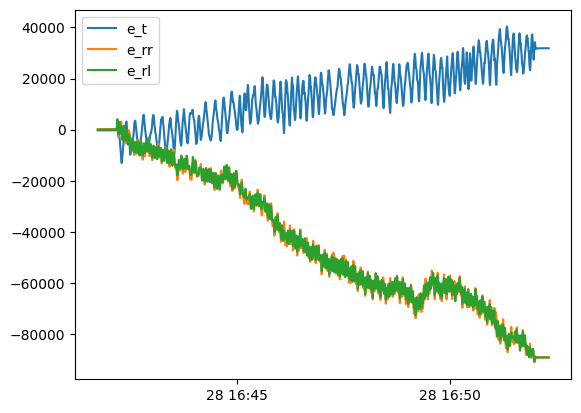

In [5]:
plt.plot(_sk_df["time"], _sk_df["e_t"], label="e_t")
plt.plot(_sk_df["time"], _sk_df["e_rr"], label="e_rr")
plt.plot(_sk_df["time"], _sk_df["e_rl"], label="e_rl")
plt.legend()


In [6]:
y = (19.5/2)/100 # meters
x = 7.5/100 # meters
radius = 5.5/200 # meters

df = _sk_df.copy()
df = set_zero(df)
df, ang_col = get_angular_velocity(df, ang_per_increment=0.09, del_t=0.01)
df, vel_col = get_directional_velocity(df, ang_col, radius=radius, x = x, y = y)
df, col_names = get_position(df)
df, _ang_name = get_orientation(df)


In [7]:
# type in marker details
_xm = get_marker_name(2)
_ym = get_marker_name(1)
_om = get_marker_name(3)

In [8]:
# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

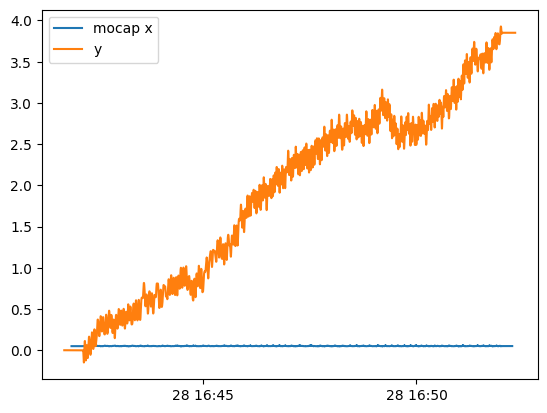

In [9]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, _mocap_df[_om["y"]], label="mocap x")
plt.plot(df.time, df["y_val"], label="y")

# plt.plot(df["w"], label="theta")
plt.legend()

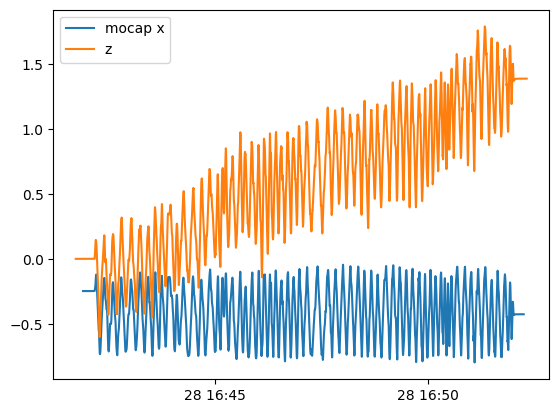

In [10]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, _mocap_df[_om["x"]] - 0.3, label="mocap x")
plt.plot(df.time, df["x_val"], label="z")

# plt.plot(df["w"], label="theta")
plt.legend()

In [11]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

yvec = [_mocap_df[_ym["x"]].iloc[0], _mocap_df[_ym["y"]].iloc[0], _mocap_df[_ym["z"]].iloc[0]]
yvec = np.array(yvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = yvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vycap = v2 - (vxnorm.T @ v2) * vxnorm
vynorm = vycap / np.linalg.norm(vycap)

vznorm = np.cross(vynorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [12]:
@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]


In [40]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 61959/61959 [00:07<00:00, 8366.97it/s]


In [39]:
# rotate along y axis
# _mc_df["x"] = _mc_df["x"] * np.cos(np.deg2rad(90)) - _mc_df["z"] * np.sin(np.deg2rad(90))

# _s = pl.Series(my_dict)
# _mc_pl_df.replace("x", my_dict["x"])
# _mc_pl_df.replace("y", my_dict["y"])
# _mc_pl_df.replace("z", my_dict["z"])

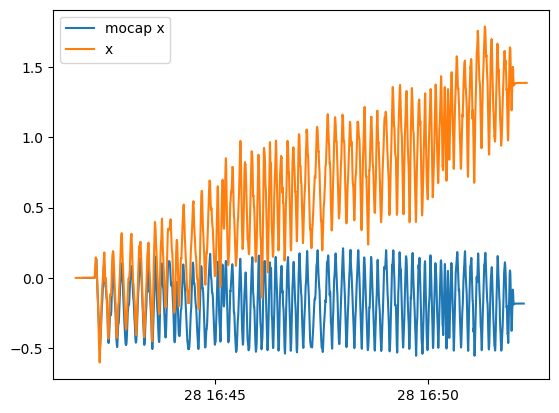

In [41]:
plt.plot(_mocap_df.time, -_mc_df.x, label="mocap x")
plt.plot(df.time, df["x_val"], label="x")

# plt.plot(df["w"], label="theta")
plt.legend()

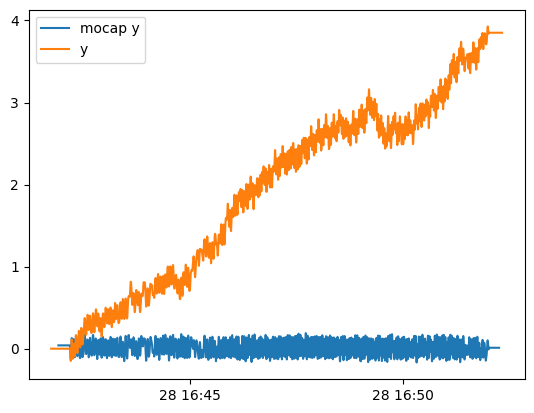

In [21]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, _mc_df.y + 0.04, label="mocap y")
plt.plot(df.time, df["y_val"], label="y")

# plt.plot(df["w"], label="theta")
plt.legend()

In [22]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _y_vec = _m_df[[_ym["x"], _ym["y"], _ym["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)


100%|██████████| 61959/61959 [00:00<00:00, 105297.00it/s]


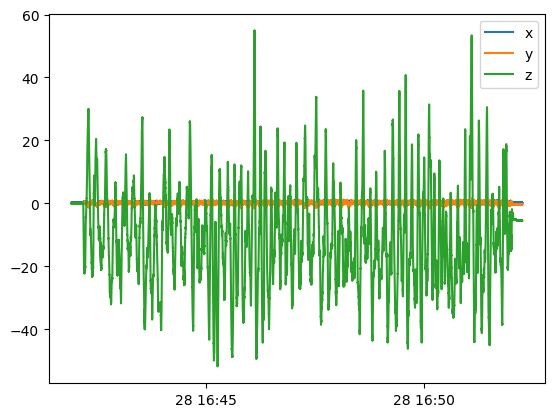

In [23]:
# plt.plot(df.time, np.rad2deg(df["theta"]), label="y")
plt.plot(_m_df["time"], _theta_x, label="x")
plt.plot(_m_df["time"], _theta_y, label="y")
plt.plot(_m_df["time"], _theta_z, label="z")
plt.legend()


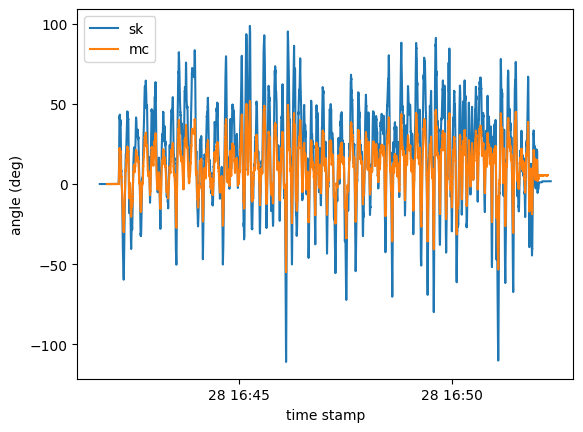

In [45]:
plt.plot(df["time"], np.rad2deg(df["theta"]), label="sk")
plt.plot(_m_df["time"], -_theta_z, label="mc")
plt.ylabel("angle (deg)")
plt.xlabel("time stamp")
plt.legend()

In [51]:
import json
f = open('analysis_pth.json')
_var = json.load(f)
f.close()
_var["pth"]


'somepath'